**Note:** the recommended standard workflow is

- shuffle
- repeat (repeat after shuffle so that one epoch = all the examples)
- map, using the num_parallel_calls argument to get multithreading for free.
- batch or padded_batch
- prefetch (will prefetch data on the GPU so that it doesn't suffer from any data starvation – and only use 80% of your expensive GPU).


# keras
https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-1-682b670d5e11

Input: 
https://www.kaggle.com/snlpnkj/bidirectional-lstm-keras !!!

# TODO
- test

In [1]:
import sys
import json
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sn
import pickle as pkl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.utils import to_categorical
from keras_contrib.layers import CRF

# from keras_contrib.layers import CRF

DATA_DIR = "../Data/4ner/"
OBJECTS_DIR = '../objects/'
PROCESSED_TRAIN_DATA_DIR = '../Data/processed/'
PROCESSED_TEST_DATA_DIR = '../Data/processed_test_data/'
LOG_DIR  = '../log/bioc_FH_training/'

Using TensorFlow backend.


In [2]:
now = datetime.now()
RESULT_DIR = Path('results/') / now.strftime("%m%d_%H%M%S")
RESULT_DIR.mkdir(exist_ok=True)

In [3]:
params = {
    'max_features': 25000,  # how many unique words to use
    'maxlen': 90,           # max num of words in one training record
    'embedding_size': 100,
    'lstm_size': 128,
    'dropout': 0.5,
    'recurrent_dropout': 0.5,
    'bi_lstm': True,
    'crf': False, # TODO: doesn't work
    'batch_size': 32,
    'epochs': 14,
}

with (RESULT_DIR/'params.json').open('w') as f:
    json.dump(params, f, indent=4, sort_keys=True)

In [4]:
def load_ner_data(path, mode, skip=2):
    """ Load training data and tags for NER
    Params:
        skip == 2: ignore training instance's index and file_name
    """
    
    words = Path(path) / f"{mode}.words.txt"
    tags = Path(path) / f"{mode}.tags.txt"
    
    with Path(words).open('r') as f_words, Path(tags).open('r') as f_tags:
        X, y = [], []
        for line_words, line_tags in zip(f_words, f_tags):
            line_words = line_words.strip().split()
            line_tags = line_tags.strip().split()
            if skip == 2:
                assert len(line_words) == len(line_tags)
            X.append(line_words[skip:])
            y.append(line_tags[skip:])
    return X, y

X_ner_train, y_ner_train = load_ner_data(DATA_DIR, 'train_doc')
X_ner_valid, y_ner_valid = load_ner_data(DATA_DIR, 'valid_doc')

In [5]:
## elmo embedding
# with open(join(PROCESSED_DIR, 'doc_156.emb.pkl'),'rb') as f:
#     doc = pkl.load(f)

In [6]:
def load_vocab_dict(path, ftype):
    file = Path(path) / f"vocab.{ftype}.txt"
    vdict = {"<PAD>": 0}
    
    with file.open() as f:
        for idx, line in enumerate(f):
            content = line.strip()
            vdict[content] = idx + 1

    return vdict

tags_dict = load_vocab_dict(DATA_DIR, "tags")
print(tags_dict)
words_index = load_vocab_dict(DATA_DIR, "words")
print(len(words_index))

{'<PAD>': 0, 'FM': 1, 'LS-0': 2, 'LS-2': 3, 'LS-4': 4, 'Maternal': 5, 'O': 6, 'OBS': 7, 'Paternal': 8}
4173


In [7]:
def sent2seq(words_index, X, tags_dict, y):
    """ Convert sentences to a sequence of indicies in word_index, and
        convert tags to its index in tags_dict
    """
    
    X_seq, y_seq = [], []
    for sent, tags in zip(X, y):
        sent_seq, tags_seq = [], []

        for word, tag in zip(sent, tags):
            if word.strip():     # skip ' '
                sent_seq.append(words_index[word])
                tags_seq.append(tags_dict[tag])
                
        assert len(sent_seq) == len(tags_seq)
        
        X_seq.append(sent_seq)
        y_seq.append(np.expand_dims(tags_seq, axis=1))
    return X_seq, y_seq

In [8]:
X_train_seq, y_train_seq = sent2seq(words_index, X_ner_train, tags_dict, y_ner_train)
X_valid_seq, y_valid_seq = sent2seq(words_index, X_ner_valid, tags_dict, y_ner_valid)
X_train_seq_len = [len(seq) for seq in X_train_seq]
X_valid_seq_len = [len(seq) for seq in X_valid_seq]

len_X_train = list(map(len, X_train_seq))
len_X_valid = list(map(len, X_valid_seq))
print("Train: avg length:", np.mean(len_X_train), "\nmax:", np.max(len_X_train))
print("Valid: avg length:", np.mean(len_X_valid), "\nmax:", np.max(len_X_valid))

X_train = pad_sequences(X_train_seq, maxlen=params['maxlen'], padding='post')
X_valid = pad_sequences(X_valid_seq, maxlen=params['maxlen'], padding='post')
y_train = pad_sequences(y_train_seq, maxlen=params['maxlen'], padding='post')
y_valid = pad_sequences(y_valid_seq, maxlen=params['maxlen'], padding='post')

Train: avg length: 14.5722049689441 
max: 63
Valid: avg length: 15.791044776119403 
max: 54


In [9]:
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
# print(X_train[0])
# print(y_train[0])

x_train shape: (1288, 90)
y_train shape: (1288, 90, 1)
X_valid shape: (469, 90)
y_valid shape: (469, 90, 1)


In [10]:
EMBEDDING_FILE = Path.home() / f"tools/glove/glove.6B.{params['embedding_size']}d.txt"

In [11]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [12]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

embedding_matrix = np.random.normal(emb_mean, emb_std,
                                    (params['max_features'], params['embedding_size']))
for word, i in words_index.items():
    if i >= params['max_features']: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [13]:
embedding = Embedding(params['max_features'],
                      params['embedding_size'],
                      input_length=params['maxlen'],
                      mask_zero=True)

class MyCRF(layers.Layer):
    def __init__(self, n_tags):
        super(MyCRF, self).__init__()
        self.crf = CRF(n_tags) # ,sparse_target=False
        #self.output_masks = self.crf.output_masks

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or 
        # manipulate it if this layer changes the shape of the input
        return mask
    
    def call(self, inputs, mask=None):
        return self.crf(inputs)

def model_LSTM(embedding, out_dim, activation='softmax'):
    model = Sequential()
    # modify as elmo embedding layer,
    # with shape (batch_size, seq_len, dim)
    model.add(embedding)
    lstm = LSTM(params['lstm_size'], return_sequences=True,
                input_shape=(params['maxlen'], params['embedding_size']),
                dropout=params['dropout'], recurrent_dropout=params['recurrent_dropout'])
    if params['bi_lstm']:
        lstm = Bidirectional(lstm)
    model.add(lstm)
    
    if params['crf']:
        # CRF
        model.add(TimeDistributed(Dense(out_dim, activation="relu")))  # a dense layer as suggested by neuralNer
        crf_layer = CRF(len(tags_dict)) #MyCRF(len(tags_dict))
        model.add(crf_layer)
        model.compile(optimizer='Rmsprop', #  opt for RNN model  # 'adam',
                      loss=crf_layer.loss_function,
                      metrics=[crf_layer.accuracy])
    else:
        model.add(Dense(out_dim, activation=activation))
        model.compile(optimizer='Rmsprop', #  opt for RNN model  # 'adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'])
    print(model.summary())
    return model


model = model_LSTM(embedding, len(tags_dict))

W1018 14:56:08.152939 139808878241536 deprecation.py:506] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1018 14:56:08.174141 139808878241536 deprecation.py:506] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W1018 14:56:08.186776 139808878241536 deprecation.py:506] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 90, 100)           2500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 90, 256)           234496    
_________________________________________________________________
dense (Dense)                (None, 90, 9)             2313      
Total params: 2,736,809
Trainable params: 2,736,809
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
print('Training...')
history = model.fit(X_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    shuffle=True,
                    validation_data=[X_valid, y_valid])

Training...


W1018 14:56:11.385088 139808878241536 deprecation.py:323] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:457: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 1288 samples, validate on 469 samples
Epoch 1/14
1288/1288 [==============================] - 11s 8ms/sample - loss: 0.1325 - acc: 0.8578 - val_loss: 0.0909 - val_acc: 0.8852
Epoch 2/14
1288/1288 [==============================] - 8s 6ms/sample - loss: 0.0784 - acc: 0.8769 - val_loss: 0.0725 - val_acc: 0.8887
Epoch 3/14
1288/1288 [==============================] - 8s 6ms/sample - loss: 0.0595 - acc: 0.8839 - val_loss: 0.0559 - val_acc: 0.8939
Epoch 4/14
1288/1288 [==============================] - 8s 6ms/sample - loss: 0.0468 - acc: 0.8971 - val_loss: 0.0528 - val_acc: 0.8982
Epoch 5/14
1288/1288 [==============================] - 8s 6ms/sample - loss: 0.0406 - acc: 0.9137 - val_loss: 0.0461 - val_acc: 0.9091
Epoch 6/14
1288/1288 [==============================] - 7s 6ms/sample - loss: 0.0357 - acc: 0.9277 - val_loss: 0.0434 - val_acc: 0.9182
Epoch 7/14
1288/1288 [==============================] - 7s 6ms/sample - loss: 0.0323 - acc: 0.9346 - val_loss: 0.0421 - val_acc: 0.9180


# Visulizing results of the training

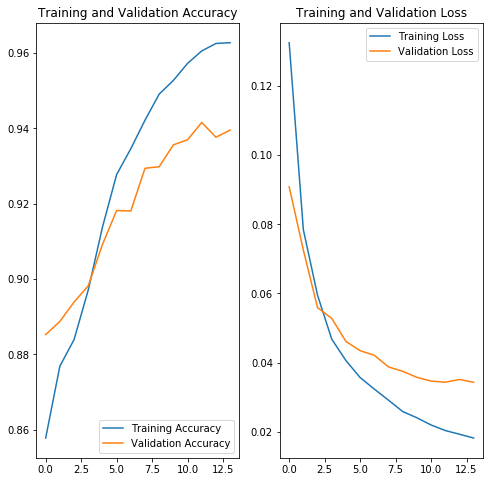

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(params['epochs'])

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./acc-loss.png')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# # prediction_probas = model.predict(X_valid) 

num2tag = {v:k for k, v in tags_dict.items()}

predictions = model.predict(X_valid)
predictions = [[np.argmax(word_pred) for word_pred in sent_pred] for sent_pred in predictions]

def mask(X, y, preds):
    for idx, instance in enumerate(X):
        assert len(X[idx]) == len(y[idx]), f"at idx {idx}"
        preds[idx] = preds[idx][:len(instance)]
        
    return preds
predictions = mask(X_valid_seq, y_valid_seq, predictions)
    
line, total, wrong = 0, 0, 0
print("word\t\tTrue\t\tPredicted")
for preds, seq in zip(predictions, y_valid_seq):
    seq = np.squeeze(seq, axis=1).tolist()
    
    for idx, (pred, label) in enumerate(zip(preds, seq)):
        if pred != label:
            wrong += 1
            print(f"{X_ner_valid[line][idx]}\t\t{y_ner_valid[line][idx]}\t\t{num2tag[pred]}")
    line += 1
    total += idx + 1
print(wrong, "wrong out of", total)

[[  80    0    0    1    3   49    1    1]
 [   0   41    0    0    0   24    0    0]
 [   0    1    0   18    0    7    0    0]
 [   0    0    0   45    0   13    1    0]
 [   6    0    0    0   40   14    0    1]
 [  21    7    0   26    6 6431   62    3]
 [   0    0    0    0    0  168  290    0]
 [   0    0    0    0    0   14    1   31]]
              precision    recall  f1-score   support

           1      0.748     0.593     0.661       135
           2      0.837     0.631     0.719        65
           3      0.000     0.000     0.000        26
           4      0.500     0.763     0.604        59
           5      0.816     0.656     0.727        61
           6      0.957     0.981     0.969      6556
           7      0.817     0.633     0.713       458
           8      0.861     0.674     0.756        46

   micro avg      0.940     0.940     0.940      7406
   macro avg      0.692     0.616     0.644      7406
weighted avg      0.935     0.940     0.936      7406



/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


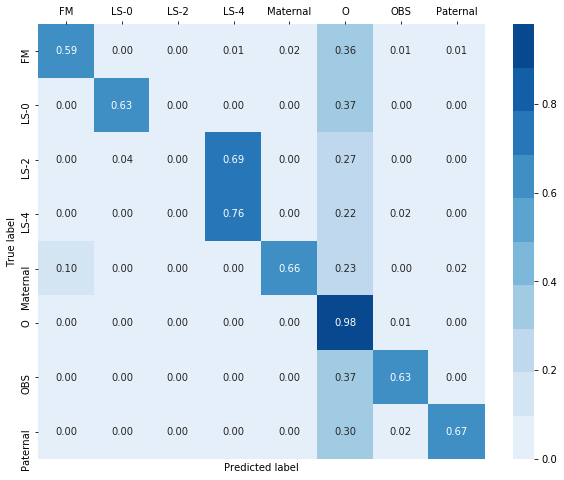

In [17]:
true_valid = [label[0] for labels in y_valid_seq for label in labels]
pred_valid = [label for labels in predictions for label in labels]

print(confusion_matrix(true_valid, pred_valid))

classes = list(tags_dict.keys())

cm = confusion_matrix(y_true=true_valid, y_pred=pred_valid)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=classes[1:], columns=classes[1:])
plt.figure(figsize=(10,8))
ax = sn.heatmap(df_cm, annot=True, fmt='.2f',cmap=sn.color_palette("Blues", n_colors=10))
ax.set(ylabel='True label', xlabel='Predicted label')
ax.xaxis.tick_top()
print(classification_report(true_valid, pred_valid, digits=3))

# Test

In [18]:
X_ner_test, y_ner_test = load_ner_data(DATA_DIR, 'test')
X_test_seq, y_test_seq = sent2seq(words_index, X_ner_test, tags_dict, y_ner_test)

len_X_test = list(map(len, X_test_seq))
print("Test: avg length:", np.mean(len_X_test), "\nmax:", np.max(len_X_test))

X_test = pad_sequences(X_test_seq, maxlen=params['maxlen'], padding='post')
y_test = pad_sequences(y_test_seq, maxlen=params['maxlen'], padding='post')

test_predictions = model.predict(X_test)
test_predictions = [[np.argmax(word_pred) for word_pred in sent_pred] for sent_pred in test_predictions]
test_predictions = mask(X_ner_test, y_ner_test, test_predictions)
# np.save(OBJECTS_DIR+'ner_elmo_test_result', test_result)

Test: avg length: 15.84520780322307 
max: 89


In [19]:
def collect_ner_result(X, preds, stage="valid"):
    i = 0
    ner_result = {}
    ner4subtask2 = {}
    last_file = ""

    # docs_pred_labels = np.load(OBJECTS_DIR + f'ner_elmo_{stage}_result.npy', allow_pickle=True)
    for idx, line in enumerate(X):
        file, sent = line[0], line[1:]

        if file != last_file:
            if last_file and doc_ner:
                ner4subtask2[last_file] = doc_ner
                ner_result[last_file] = list(fms) + list(obs)
        
            fms = set()
            obs = set() # a set for each txt_file
            doc_ner = []
            last_file = file
            

        last_class, last_content = "", []
        sent_ner = []
        pred = preds[idx]

        for tid, token in enumerate(sent):
            if stage == "valid" and classes[pred[tid]] != classes[true_valid_labels[tid]]:
                print('\t\t'.join([token,
                                   classes[pred[tid]],
                                   classes[true_valid_labels[tid]]]))
            try:
                pred_class = classes[pred[tid]]
            except:
                print(sent, '\n',pred)
            i += 1
            if pred_class in ["FM", "Paternal", "Maternal"]:
                sent_ner.append(pred_class)
                if token.capitalize().rstrip('s') in ["Father", "Mother", "Parent",
                    "Sister", "Brother", "Daughter", "Son", "Child", "Grandmother", \
                    "Grandfather", "Grandparent", "Cousin", "Sibling", \
                    "Aunt", "Uncle"]:

                    if pred_class == 'FM':
                        fms.add(("FamilyMember", token.capitalize().rstrip('s'), "NA"))
                    else:
                        fms.add(("FamilyMember",
                                 token.capitalize().rstrip('s'),
                                 pred_class))
                elif token.lower() == 'dad':
                    fms.add(("FamilyMember", "Father", "NA"))
                elif token.lower() == 'mom':
                    fms.add(("FamilyMember", "Mother", "NA"))
                else:
                    # print("ignore:", token, pred_class)
                    sent_ner[-1] = "O"  # modify the last label untill now
            elif pred_class == last_class and pred_class == "OBS":
                last_content += [token]
                sent_ner.append("OBS")
            elif pred_class.startswith("LS"):
                sent_ner.append(pred_class)
            else: # not the same label as the last label
                if last_class == 'OBS' and last_content:
                    obs.add(("Observation", " ".join(last_content)))

                if pred_class == "OBS":
                    last_class, last_content = pred_class, [token]
                    sent_ner.append("OBS")
                else:
                    last_class, last_content = "", []
                    sent_ner.append("O")
        doc_ner.append(sent_ner)

    
    wfile = Path(RESULT_DIR) / f'sub1.result.{stage}.lstm.tsv'
    with wfile.open('w') as f:
        for txt_file, content in ner_result.items():
            for items in content:
                f.write("\t".join([txt_file] + list(items)) + '\n')

    return ner4subtask2

X_ner_valid, _ = load_ner_data(DATA_DIR, 'valid_doc', 1)
valid_ner4subtask2 = collect_ner_result(X_ner_valid, predictions, "valid_doc")
X_ner_test, _ = load_ner_data(DATA_DIR, 'test', 1)
test_ner4subtask2 = collect_ner_result(X_ner_test, test_predictions, "test")

In [ ]:
print(test_ner4subtask2)